What's new in this version?

- Hyperparameter tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
# import xgboost

from pathlib import Path

%matplotlib notebook

In [2]:
csv_glob = list(Path('../data/').glob('*_weather.csv'))

CACHE_PATH = '../data/FINAL_DATA_v2.csv'
DO_CACHE = True

mapper = {x.name.split('_')[0]: x for x in csv_glob}
print(mapper)

{'EWR': PosixPath('../data/EWR_weather.csv'), 'DEN': PosixPath('../data/DEN_weather.csv'), 'IAD': PosixPath('../data/IAD_weather.csv'), 'ORD': PosixPath('../data/ORD_weather.csv'), 'SYR': PosixPath('../data/SYR_weather.csv')}


In [3]:
def preprocess_weather_df(df):
    df['time'] = pd.to_datetime(df['time'])
    df['Date'] = pd.to_datetime(df.time.apply(lambda x: x.date()))
    df['Time'] = df.time.apply(lambda x: x.time())
    df.drop(columns=['time'], inplace=True, axis='columns')
    return df


def create_label(arrival_delay):
    if arrival_delay < -10:
        return "early"
    if -10 <= arrival_delay <= 10:
        return "on_time"
    if 10 < arrival_delay <= 30:
        return "delayed"
    if arrival_delay > 30:
        return "severely_delayed"
    
    raise NotImplementedError("unknown timeframe")

    
def create_data_df():
    
    if not DO_CACHE:
        return pd.read_csv(CACHE_PATH)

    anchor_df = pd.read_csv('../data/Detailed_Statistics_Arrivals.csv')

    #drop any NaNs.
    anchor_df.dropna(inplace=True, axis='rows')

    # Remove carrier code, tail number
    # Rename Flight Number

    anchor_df['Date (MM/DD/YYYY)'] = pd.to_datetime(anchor_df['Date (MM/DD/YYYY)'])
    anchor_df.drop(columns=['Carrier Code', 'Tail Number'], axis='columns', inplace=True)
    anchor_df['Flight Number'] = anchor_df['Flight Number'].apply(lambda x: "UA " + str(int(x)))
    anchor_df['Scheduled Arrival Time'] = pd.to_datetime(anchor_df['Scheduled Arrival Time'])
    anchor_df['Arrival Time (Rounded)'] = anchor_df['Scheduled Arrival Time'].dt.round('H')
    anchor_df['Scheduled Arrival Time'] = anchor_df['Scheduled Arrival Time'].apply(lambda x: x.time())
    anchor_df['DayOfWeek'] = anchor_df['Date (MM/DD/YYYY)'].dt.dayofweek

    # Arrival time.
    anchor_df['Arrival Time (Rounded)'] = anchor_df['Arrival Time (Rounded)'].apply(lambda x: x.time())
    
    display(anchor_df)
    
    # ------------------------------
    
    airport_dfs = []
    for airport_name in anchor_df['Origin Airport'].unique():

        sub_df = anchor_df.loc[anchor_df['Origin Airport'] == airport_name, :].reset_index(
            drop=True, inplace=False
        )

        weather_df = preprocess_weather_df(pd.read_csv(mapper[airport_name]))

        merged = sub_df.merge(
            right=weather_df,
            left_on=['Date (MM/DD/YYYY)', 'Arrival Time (Rounded)'],
            right_on=['Date', 'Time'],
            how='inner'
        ).reset_index(drop=True, inplace=False)

        airport_dfs.append(merged)
    
    # ------------------------------
    
    df = pd.concat(airport_dfs, axis=0)
    df = df.sort_values(
        by=['Origin Airport', 'Date (MM/DD/YYYY)'], 
        axis=0, 
        inplace=False
    ).reset_index(drop=True, inplace=False)
    
    # ------------------------------
    
    # Add SYR weather.
    syr_weather = preprocess_weather_df(pd.read_csv(mapper['SYR']))
    syr_weather.columns = ['syr_' + x for x in syr_weather.columns]

    df = df.merge(
            right=syr_weather,
            left_on=['Date (MM/DD/YYYY)', 'Arrival Time (Rounded)'],
            right_on=['syr_Date', 'syr_Time'],
            how='inner'
        ).reset_index(drop=True, inplace=False)
    
    # ------------------------------
    
    df['arrival_status'] = df['Arrival Delay (Minutes)'].apply(lambda x: create_label(x))
    
    df.drop(
        columns=[
            'Date (MM/DD/YYYY)',
            'Scheduled Arrival Time',
            'Actual Arrival Time',
            'Scheduled Elapsed Time (Minutes)',
            'Actual Elapsed Time (Minutes)',
            'Arrival Delay (Minutes)',                 # TODO: Think about this.
            'Delay Carrier (Minutes)',
            'Delay Weather (Minutes)',
            'Delay National Aviation System (Minutes)',
            'Delay Security (Minutes)', 
            'Delay Late Aircraft Arrival (Minutes)',
            'Arrival Time (Rounded)', 
            'Date', 
            'Time',
            'syr_Date',
            'syr_Time'
        ], axis='columns', inplace=True
    )
    
    return df

In [4]:
df = create_data_df()

print(df.shape)

,Date (MM/DD/YYYY),Flight Number,Origin Airport,Scheduled Arrival Time,Actual Arrival Time,Scheduled Elapsed Time (Minutes),Actual Elapsed Time (Minutes),Arrival Delay (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes),Arrival Time (Rounded),DayOfWeek
0,2022-01-01,UA 1282,IAD,23:10:00,00:01,70.0,76.0,51.0,23.0,0.0,6.0,0.0,22.0,23:00:00,5
1,2023-01-01,UA 604,DEN,14:58:00,14:52,193.0,177.0,-6.0,0.0,0.0,0.0,0.0,0.0,15:00:00,6
2,2023-01-01,UA 2488,EWR,23:14:00,23:15,75.0,62.0,1.0,0.0,0.0,0.0,0.0,0.0,23:00:00,6
3,2023-01-01,UA 2645,ORD,23:57:00,23:47,107.0,100.0,-10.0,0.0,0.0,0.0,0.0,0.0,00:00:00,6
4,2022-01-02,UA 1282,IAD,23:10:00,23:27,70.0,64.0,17.0,17.0,0.0,0.0,0.0,0.0,23:00:00,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,2019-12-31,UA 1460,EWR,18:15:00,18:14,75.0,60.0,-1.0,0.0,0.0,0.0,0.0,0.0,18:00:00,1
2145,2021-12-31,UA 467,IAD,18:38:00,18:32,78.0,68.0,-6.0,0.0,0.0,0.0,0.0,0.0,19:00:00,4
2146,2022-12-31,UA 604,DEN,14:58:00,14:46,193.0,178.0,-12.0,0.0,0.0,0.0,0.0,0.0,15:00:00,5
2147,2022-12-31,UA 1998,ORD,21:08:00,20:44,113.0,98.0,-24.0,0.0,0.0,0.0,0.0,0.0,21:00:00,5


(2090, 40)


<IPython.core.display.Javascript object>


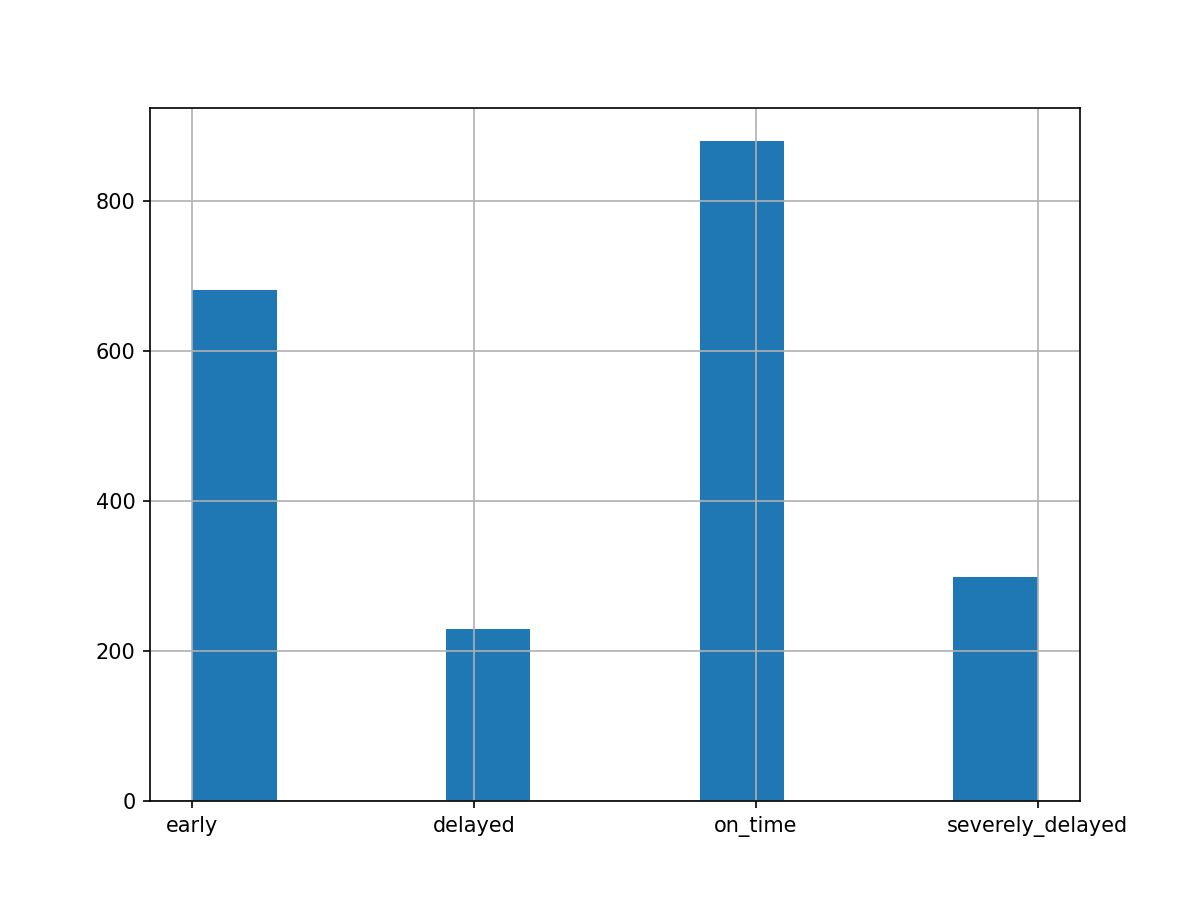

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
df['arrival_status'].hist(ax=ax)
plt.show()

### Modeling

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [8]:
# OHE
# flight_number_encoder = OneHotEncoder()
origin_airport_encoder = OneHotEncoder()
day_of_week_encoder = OneHotEncoder()

# flight_number_ohe = flight_number_encoder.fit_transform(df[['Flight Number']].values).toarray()
airport_ohe = origin_airport_encoder.fit_transform(df[['Origin Airport']].values).toarray()
day_of_week_ohe = day_of_week_encoder.fit_transform(df[['DayOfWeek']].values).toarray()

# flight_number_ohe = pd.DataFrame(
#     flight_number_ohe, 
#     columns=flight_number_encoder.get_feature_names_out()
# )

airport_ohe = pd.DataFrame(
    airport_ohe,
    columns=origin_airport_encoder.get_feature_names_out()
)

day_of_week_ohe = pd.DataFrame(
    day_of_week_ohe,
    columns=day_of_week_encoder.get_feature_names_out()
)

# Join
# df = pd.concat([df, flight_number_ohe, airport_ohe], axis=1)
df = pd.concat([df, airport_ohe, day_of_week_ohe], axis=1)

df.drop(
    columns=[
        'Flight Number', 
        'Origin Airport',
        'DayOfWeek'
    ],
    axis='columns',
    inplace=True
)

In [9]:
df.dropna(axis='rows', inplace=True)

In [10]:
if DO_CACHE:
    df.to_csv(CACHE_PATH, index=False)

In [11]:
X = df.loc[:, ~df.columns.isin(['arrival_status'])]
Y = df.loc[:, 'arrival_status']

X_tr, X_te, Y_tr, Y_te = train_test_split(X, Y, shuffle=True, random_state=420, stratify=Y)

print(f"{X_tr.shape=}, {X_te.shape=}, {Y_tr.shape=}, {Y_te.shape=}")

X_tr.shape=(1567, 47), X_te.shape=(523, 47), Y_tr.shape=(1567,), Y_te.shape=(523,)


In [12]:
scaler = StandardScaler()
X_tr_scaled = pd.DataFrame(scaler.fit_transform(X_tr), columns=scaler.feature_names_in_)
X_te_scaled = pd.DataFrame(scaler.transform(X_te), columns=scaler.feature_names_in_)

In [13]:
# with open('../models/data_scaler.pkl', 'wb') as f:
#     f.write(pickle.dumps(scaler))

# with open('../models/flight_number_encoder.pkl', 'wb') as f:
#     f.write(pickle.dumps(flight_number_encoder))
    
# with open('../models/origin_airport_encoder.pkl', 'wb') as f:
#     f.write(pickle.dumps(origin_airport_encoder))

In [43]:
# plot stats
def plot_stats(best_model, X_te, Y_te):
    pred_df = pd.DataFrame(
        {
            'y_true': Y_te,
            'y_pred': best_model.predict(X_te)
        }
    )
    
    n_correct = pred_df.loc[pred_df.y_true == pred_df.y_pred, :].shape[0]
    print("Number of correct predictions: ", n_correct)
    print("% of correct predictions: ", (n_correct/pred_df.shape[0])*100.)
    
    if 'feature_importances_' in dir(best_model) and 'feature_names_in_' in dir(best_model):
        feature_df = pd.DataFrame(columns=['feature_name', 'importance'])
        feature_df['feature_name'] = best_model.feature_names_in_
        feature_df['importance'] = best_model.feature_importances_
        feature_df.sort_values(by='importance', ascending=False, inplace=True, axis=0)
        print(feature_df.feature_name.tolist()[:15])
        display(feature_df.head(15))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(pred_df.y_true, color='blue')
    ax.hist(pred_df.y_pred, color='red')
    ax.set_title('Ground truth')
    ax.set_title('Predictions')
    ax.legend(['Ground Truths', 'Predicted'], loc='best')
    plt.show()
    

# Grab the best model.
def get_best_model(performance_dict, metric='test', return_ix=False):
    if metric not in ['train', 'test']:
        raise NotImplementedError("Unknown metric type")
    
    if metric == 'train':
        argmax = np.argmax(performance_dict['train'])
        model = performance_dict['models'][argmax]
    else:
        argmax = np.argmax(performance_dict['test'])
        model = performance_dict['models'][argmax]
        
    if not return_ix:
            return model, -1
    else:
        return model, argmax

In [22]:
## Logistic regression

from sklearn.linear_model import LogisticRegression
logistic_params = {
    'C': np.arange(0.1, 1, 0.1).tolist() + np.arange(1.0, 10., 0.5).tolist(),
    'fit_intercept': [True],
    'class_weight': ['balanced'],
    'solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'max_iter': list(range(500, 2000, 250))
}

performance = {'train': [], 'test': [], 'models': [], 'kwargs': []}

max_sweeps = 200

for ix in tqdm(range(max_sweeps)):
    params = {k: np.random.choice(logistic_params[k]) for k in logistic_params.keys()}
    model = LogisticRegression(**params).fit(X_tr_scaled, Y_tr)
    performance['kwargs'].append(params)
    performance['train'].append(model.score(X_tr_scaled,Y_tr))
    performance['test'].append(model.score(X_te_scaled,Y_te))
    performance['models'].append(model)

 10%|▉         | 19/200 [00:03<00:33,  5.44it/s]


KeyboardInterrupt: 

In [ ]:
best_logistic_model, ix = get_best_model(performance, metric='test', return_ix=True)

print("train R2: ", performance['train'][ix])
print("test R2: ", performance['test'][ix])

In [ ]:
plot_stats(best_logistic_model, X_te_scaled, Y_te)

## Random forest

In [46]:
from sklearn.ensemble import RandomForestClassifier
from concurrent.futures import ProcessPoolExecutor

rf_params = {
    'n_estimators': list(range(20, 500, 5)),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': list(range(10, 200, 10)),
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [2, 3, 4, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'warm_start': [True, False],
    'n_jobs': [8],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

performance = {'train': [], 'test': [], 'models': []}

max_sweeps = 400

for ix in tqdm(range(max_sweeps)):
    params = {k: np.random.choice(rf_params[k]) for k in rf_params.keys()}
    model = RandomForestClassifier(**params).fit(X_tr_scaled, Y_tr)
    performance['train'].append(model.score(X_tr_scaled,Y_tr))
    performance['test'].append(model.score(X_te_scaled,Y_te))
    performance['models'].append(model)

  0%|          | 2/400 [00:04<13:41,  2.06s/it]/home/altafuturis/miniconda3/envs/work/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn(
  2%|▏         | 8/400 [00:16<12:19,  1.89s/it]/home/altafuturis/miniconda3/envs/work/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:777: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can 

KeyboardInterrupt: 

In [35]:
best_rf_model, ix = get_best_model(
    performance,
    metric='test',
    return_ix=True
)

print("train R2: ", performance['train'][ix])
print("test R2: ", performance['test'][ix])

train R2:  0.8353541799617102
test R2:  0.4780114722753346


In [36]:
# dir(best_rf_model)
best_rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 140,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 120,
 'n_jobs': 8,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': True}

Number of correct predictions:  250
% of correct predictions:  47.801147227533455
['dewpoint_2m', 'surface_pressure', 'syr_dewpoint_2m', 'winddirection_10m', 'pressure_msl', 'syr_surface_pressure', 'syr_windgusts_10m', 'relativehumidity_2m', 'syr_pressure_msl', 'syr_winddirection_10m', 'temperature_2m', 'windspeed_10m', 'apparent_temperature', 'vapor_pressure_deficit', 'windgusts_10m']


,feature_name,importance
2,dewpoint_2m,0.046094
5,surface_pressure,0.044904
20,syr_dewpoint_2m,0.037981
14,winddirection_10m,0.037416
4,pressure_msl,0.036839
23,syr_surface_pressure,0.036622
33,syr_windgusts_10m,0.035262
1,relativehumidity_2m,0.035069
22,syr_pressure_msl,0.033509
32,syr_winddirection_10m,0.033137


<IPython.core.display.Javascript object>


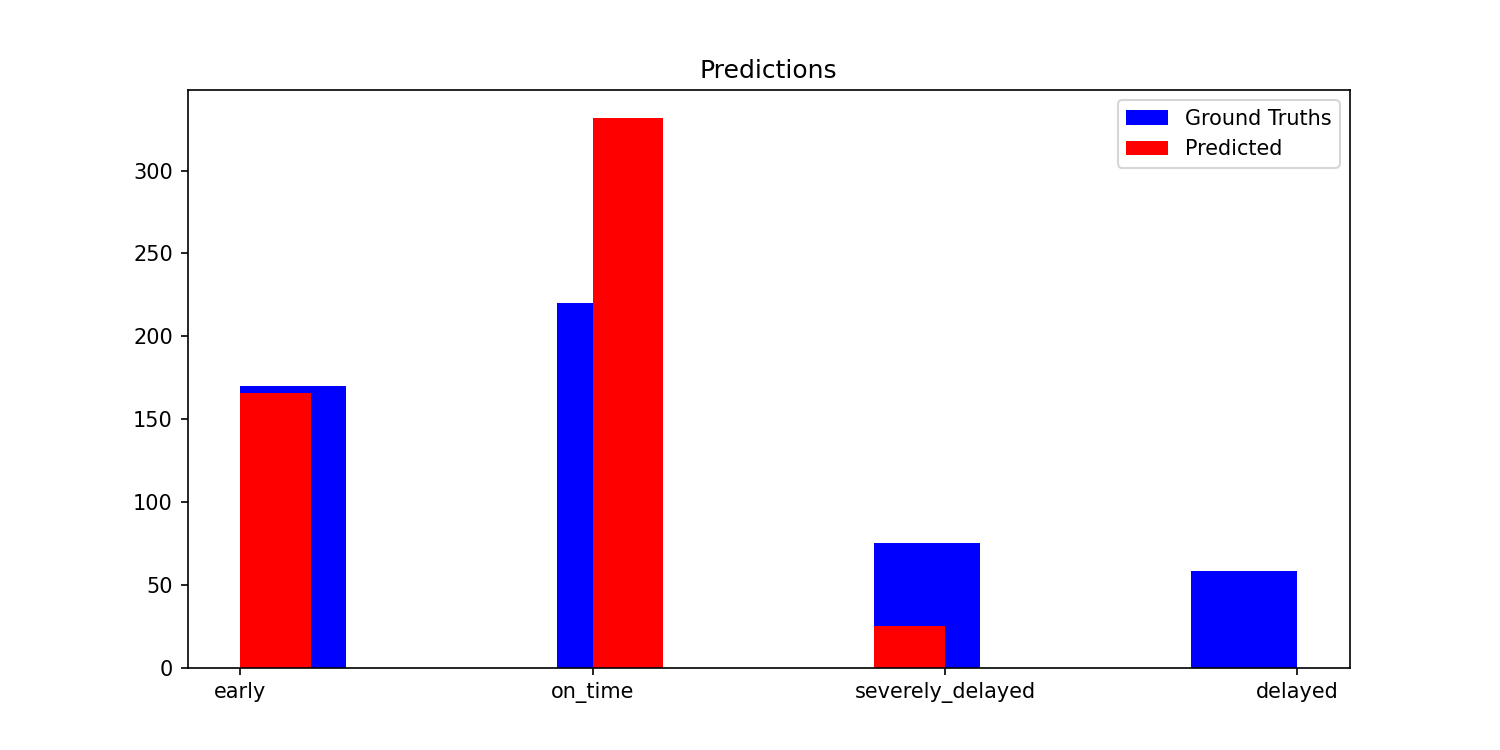

In [44]:
plot_stats(best_rf_model, X_te_scaled, Y_te)

## Gradient-boosted tree 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

max_sweeps = 100
performance = {'train': [], 'test': [], 'models': []}

model_params = {
    'n_estimators': [10, 25, 50, 100, 150, 200, 250],
    'loss': ['log_loss'],
    'criterion': ['friedman_mse', 'squared_error'],
    'min_samples_split': [2,3,4,5],
    'min_samples_leaf': [2,3,4,5],
    'max_depth': [10, 30, 50, 70, 100],
    'max_features': ['sqrt', 'log2', None]
}

for ix in tqdm(range(max_sweeps)):
    params = {k: np.random.choice(model_params[k]) for k in model_params.keys()}
    model = GradientBoostingClassifier(**params).fit(X_tr_scaled, Y_tr)
    performance['train'].append(model.score(X_tr_scaled,Y_tr))
    performance['test'].append(model.score(X_te_scaled,Y_te))
    performance['models'].append(model)

In [ ]:
best_gb_model, ix = get_best_model(performance, metric='test', return_ix=True)

print("train R2: ", performance['train'][ix])
print("test R2: ", performance['test'][ix])

In [ ]:
plot_stats(best_gb_model, X_te_scaled, Y_te)

In [38]:
import pickle

with open('../models/rf_model.pkl', 'wb') as f:
    f.write(pickle.dumps(best_rf_model))
